In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

tf.compat.v1.enable_v2_behavior()

from curiosity import m_passthrough_action

In [3]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule as pruning_sched
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

In [4]:
def matrix_dist(A, B):
    return np.linalg.norm((A - B).flatten(), ord=1)

In [5]:
# "model of the environment"
A = np.array([
    [1,0,1,0], # state and action, gives s_1
    [0,1,0,1],
])

# transform for the state
Q1 = np.random.randn(2, 2)

# transform for state+action
Q = np.eye(4)
Q[:2, :2] = Q1

# number of data pts
N = 1000

# states
xs = np.random.randn(4, N)

# next states
ys = A @ xs

xs_e = Q @ xs
ys_e = Q1 @ ys

# states
xs = xs.T
ys = ys.T

# observations
xs_e = xs_e.T
ys_e = ys_e.T

In [6]:
# checking that the model works correctly
assert np.allclose(A @ (np.linalg.inv(Q) @ xs_e[0]), ys[0])
assert np.allclose(xs_e[0][2:], xs[0][2:])

1000/1000 [==============================] - 0s 40us/sample - loss: 0.0058
0.005777317818254232
[<tf.Variable 'sequential/dense/kernel:0' shape=(4, 2) dtype=float32, numpy=
array([[ 9.9999982e-01, -3.4779450e-03],
       [-1.0212220e-08,  9.0061408e-01],
       [ 9.9999934e-01, -2.4173937e-03],
       [-4.0995943e-08,  9.6122342e-01]], dtype=float32)>, <tf.Variable 'sequential/dense/bias:0' shape=(2,) dtype=float32, numpy=array([4.3519279e-08, 2.9487954e-03], dtype=float32)>]
0.14405871809865012


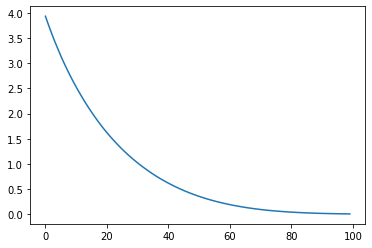

In [7]:
# checking that data is correctly generated
m = tf.keras.Sequential([tf.keras.layers.Dense(2)])
m.compile('adam', 'mse')
h = m.fit(xs, ys, epochs=100, verbose=0)
plt.plot(h.history['loss'])
print(m.evaluate(xs, ys))
print(m.weights)
print(matrix_dist(m.weights[0].numpy().T, A))

In [163]:
l1coeff = 2e-5
l2coeff = 0
sparsity = 0.3

pruning_params = {
        #'pruning_schedule': pruning_sched.ConstantSparsity(sparsity, 0),
        'pruning_schedule': pruning_sched.PolynomialDecay(0, 0.3, 0, 100),
        'block_size': (1, 1),
        'block_pooling_type': 'AVG'
    }

def component_diff_normalized(v):
    """How much the vector is close to (1,0) or (0,1)."""
    v = np.abs(v)
    return 1. - (max(v) - min(v)) / max(v)

def vec_angle_normalized(v1, v2):
    """Cos betweeen vectors."""
    return np.abs(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

def repr_quality(A):
    """Loss for representation quality for matrix A."""
    [s_1, s_2] = A.T # basis vectors = columns
    return component_diff_normalized(s_1) + \
           component_diff_normalized(s_2) + \
           vec_angle_normalized(s_1, s_2)

def get_results(l1coeff):

    inp_dec = tf.keras.Input(shape=(2,))
    
    decoder = tf.keras.Sequential([
        inp_dec,
        tf.keras.layers.Dense(2, activation=None, use_bias=False, #kernel_regularizer=tf.keras.regularizers.l2(l2coeff),
                             #kernel_initializer='random_normal',
                             #kernel_constraint=tf.keras.constraints.UnitNorm()
                             kernel_constraint=tf.keras.constraints.MinMaxNorm(0.5, 1.5)
                             ),
    ])
    
    encoder_model = tf.keras.Sequential([
        tf.keras.Input(shape=(2,)),
        tf.keras.layers.Dense(2, activation=None, use_bias=False, #kernel_regularizer=tf.keras.regularizers.l2(l2coeff),
                             #kernel_initializer='random_normal',
                             #kernel_constraint=tf.keras.constraints.UnitNorm()
                             kernel_constraint=tf.keras.constraints.MinMaxNorm(0.5, 1.5)
                             ),
    ])

    # maps observations to features
    model = tf.keras.Sequential([
        m_passthrough_action(decoder, 2, 2),
        tf.keras.Input(shape=(4,)),
        #prune.prune_low_magnitude(
            tf.keras.layers.Dense(2, activation=None, use_bias=False, kernel_regularizer=tf.keras.regularizers.l1(l1coeff),
                                 #kernel_initializer='random_normal'
                                 ),
        #**pruning_params)
    ])
    
    def loss_with_decoder(y_true, y_pred, x=None):
        L = tf.reduce_mean(tf.abs(y_pred - decoder(y_true)))
        if x is not None:
            x = x[:,:2]
            L += 10 * tf.reduce_mean(tf.abs(encoder_model(decoder(x)) - x))
        return L
    
    optimizer = tf.keras.optimizers.Adam(lr=0.001)

    def step(xs, ys):
        with tf.GradientTape() as tape:
            # Make prediction
            pred_y = model(np.array(xs, dtype=np.float32))
            # Calculate loss
            model_loss = loss_with_decoder(ys, pred_y, xs)

        # Calculate gradients
        model_gradients = tape.gradient(model_loss, model.trainable_variables)
        # Update model
        optimizer.apply_gradients(zip(model_gradients, model.trainable_variables))


    model.compile(optimizer='adam', loss=loss_with_decoder)

    losses = []
    distances = []
    for _ in tqdm(range(10)):
        x_train = xs_e
        y_train = ys_e
        batch_size=16
        epochs=10
        bat_per_epoch = int(len(x_train) / batch_size)
        for epoch in range(epochs):
            #print('=', end='')
            for i in range(bat_per_epoch):
                n = i * batch_size
                step(x_train[n:n+batch_size], y_train[n:n+batch_size])
        
        #h = model.fit(xs_e, ys_e, epochs=10, batch_size=16, verbose=0)#, callbacks=[pruning_callbacks.UpdatePruningStep()])
        loss = model.evaluate(xs_e, ys_e, verbose=0)
        DE = decoder.weights[0].numpy().T @ Q1
        #DE = DE / DE[0, 0]
        #dist = matrix_dist(DE, np.eye(2)) # it can swap them as well...
        #l1, l2 = np.linalg.eig(DE.T @ DE)[0]
        #DE = DE / np.max(DE, axis=0)
        #dist = min(matrix_dist(DE, np.eye(2)), matrix_dist(DE, np.eye(2)[:,[1,0]]))
        dist = repr_quality(DE)
        #dist = np.abs(np.abs(l1) - np.abs(l2))
        losses.append(loss)
        distances.append(dist)
    return losses, distances, model, DE, encoder_model

In [159]:
l1regs = np.logspace(-5, -3, 5)
repetitions = 2

  0%|          | 0/5 [00:00<?, ?it/s]

=WARNING:tensorflow:Layer dense_334 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


 20%|██        | 1/5 [00:03<00:14,  3.50s/it]

 40%|████      | 2/5 [00:07<00:10,  3.51s/it]

 60%|██████    | 3/5 [00:10<00:06,  3.48s/it]

 80%|████████  | 4/5 [00:14<00:03,  3.52s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

=WARNING:tensorflow:Layer dense_337 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


 20%|██        | 1/5 [00:03<00:14,  3.56s/it]

 40%|████      | 2/5 [00:07<00:10,  3.56s/it]

 60%|██████    | 3/5 [00:10<00:07,  3.54s/it]

 80%|████████  | 4/5 [00:14<00:03,  3.54s/it]

100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


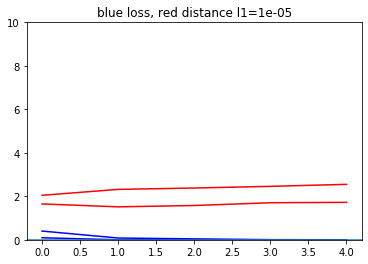

  0%|          | 0/5 [00:00<?, ?it/s]

=WARNING:tensorflow:Layer dense_340 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


 20%|██        | 1/5 [00:03<00:13,  3.49s/it]

==

 20%|██        | 1/5 [00:04<00:16,  4.08s/it]


KeyboardInterrupt: 

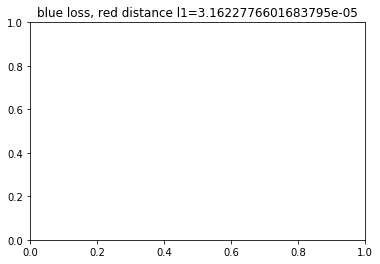

In [153]:
for l1 in l1regs:
    plt.figure()
    plt.title("blue loss, red distance l1=%s" % str(l1))
    for _ in range(repetitions):
        losses, distances, _, _, _ = get_results(l1)
        plt.plot(losses, color='blue')
        plt.plot(distances, color='red')
    plt.axhline(0)
    plt.ylim(0, 10)
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


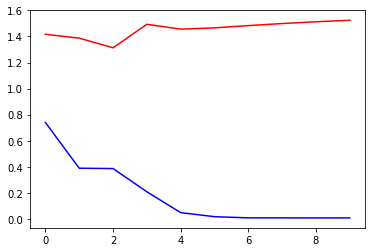

In [172]:
losses, distances, model, DE, enc_model = get_results(1e-3)
plt.plot(losses, color='blue')
plt.plot(distances, color='red')

In [171]:
DE

array([[1.01115143, 1.27647053],
       [0.01448598, 0.65488406]])

In [165]:
model.weights

[<tf.Variable 'dense_349/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.8578968 ,  0.6711588 ],
        [-0.67867035, -0.35187235]], dtype=float32)>,
 <tf.Variable 'dense_351/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[ 1.00011015e+00,  3.45473236e-04],
        [-1.40743126e-04,  9.99669671e-01],
        [ 1.01090324e+00,  1.45456055e-02],
        [ 1.27668142e+00,  6.56009495e-01]], dtype=float32)>]

In [166]:
enc_model.weights

[<tf.Variable 'dense_350/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.46473598, -0.8858308 ],
        [ 0.89586246, -1.1324092 ]], dtype=float32)>]

Problem: the example doesn't work
Anothe problem: $|\lambda_1|\approx|\lambda_2|$ is only a necessary condition but not sufficient...

And it's also not necessary -- can have (1, 2) and then it's not about this at all...

In [78]:
model.weights

[<tf.Variable 'dense_275/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.4931337 ,  1.1180147 ],
        [-0.08453786, -0.19184949]], dtype=float32)>,
 <tf.Variable 'dense_276/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[ 0.19569884, -0.40586734],
        [ 0.35487092,  1.1795061 ],
        [-0.1481647 , -0.3354655 ],
        [ 0.15505023,  0.35242257]], dtype=float32)>]

In [169]:
[s1, s2] = enc_model.weights[0].numpy().T
model.weights[0], s1, s2
vec_angle_normalized(s1, s2)

0.41544253

In [170]:
s1/s2 # it is bad... two features are the same.

array([ 0.5246329 , -0.79111195], dtype=float32)

How to regularize foe the number of non-zero elements? Use SparseSep instead of l1 https://arxiv.org/pdf/1701.06967.pdf

How to evaluate the transform $DE=?$ it should be the right vectors, but they can be scaled and permuted. Therefore, we use the following metric: L1+L2+L3, where L1=difference between two components for first vector, L2 for the second and L3 the dot product between the two (should be 0)

add constraint on mean/variance of features?

In [16]:
A = np.random.randn(2, 2)
A

array([[ 0.11062729,  1.0961417 ],
       [ 2.01711932, -0.97958002]])

In [21]:
s_2

array([ 1.0961417 , -0.97958002])

In [45]:
repr_quality(A)

1.573023080126135

In [46]:
A

array([[ 0.11062729,  1.0961417 ],
       [ 2.01711932, -0.97958002]])

In [47]:
repr_quality(np.eye(2))

0.0

In [57]:
component_diff_normalized([-1000,2])

0.0020000000000000018